In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [39]:
# Carregando os dados e ajustando o datetime
tsla_data = pd.read_csv("data/TSLA.csv")
tsla_data["Date"] = pd.to_datetime(tsla_data["Date"])

tsla_data = pd.Series(tsla_data["Adj Close"].values, index = tsla_data["Date"])
tsla_data

Date
2010-06-29      1.592667
2010-06-30      1.588667
2010-07-01      1.464000
2010-07-02      1.280000
2010-07-06      1.074000
                 ...    
2024-08-15    214.139999
2024-08-16    216.119995
2024-08-19    222.720001
2024-08-20    221.100006
2024-08-21    223.270004
Length: 3561, dtype: float64

In [40]:
# Função para calcular a média móvel exponencial dos dados
def moving_average(data, size):
    average = data.ewm(span = size, adjust = False).mean()
    return average

In [41]:
# Função do cruzamento de médias móveis
def ma_crossover(long_average, short_average):
    # Fazendo a interseção dos valores das médias de acordo com as datas
    long_average_aligned, short_average_aligned = long_average.align(short_average, join = "inner")
    # Calculando a diferença entre as médias
    diff = short_average_aligned - long_average_aligned
    # Calculando a variação diária da média curta
    short_average_var = short_average_aligned.diff()
    
    # Se a média curta está maior que a longa e está subindo, compra
    diff[(diff * short_average_var > 0) & (diff > 0)] = 1
    # Se a média curta está menor que a longa e está descendo, vende
    diff[(diff * short_average_var > 0) & (diff < 0)] = -1
    # Se a média curta está menor que a longa e está subindo ou maior e descendo, fica neutro
    diff[diff * short_average_var < 0] = 0

    return diff

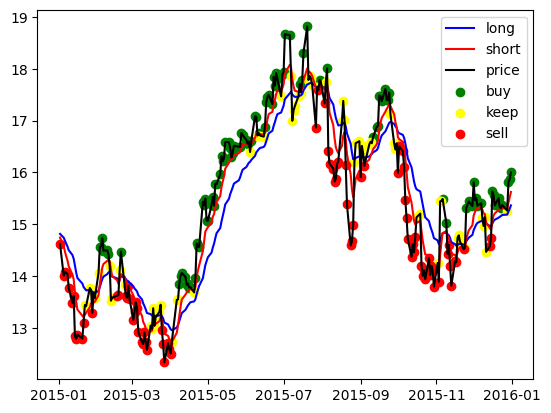

In [43]:
# Médias longa e curta
long_average = moving_average(tsla_data, 21)
short_average = moving_average(tsla_data, 8)
evaluations = ma_crossover(long_average, short_average)

# Datas de início e fim do intervalo do gráfico
start_date = "2015-01-01"
stop_date = "2016-01-01"

# Eventos de compra e venda do período
buys = evaluations[(evaluations.index > start_date) & (evaluations.index < stop_date) & (evaluations.values == 1)].index
keeps = evaluations[(evaluations.index > start_date) & (evaluations.index < stop_date) & (evaluations.values == 0)].index
sells = evaluations[(evaluations.index > start_date) & (evaluations.index < stop_date) & (evaluations.values == -1)].index

plt.plot(long_average[(long_average.index > pd.to_datetime(start_date)) & (long_average.index < pd.to_datetime(stop_date))], color = "blue", label = "long")
plt.plot(short_average[(short_average.index > pd.to_datetime(start_date)) & (short_average.index < pd.to_datetime(stop_date))], color = "red", label = "short")
plt.plot(pd.Series(tsla_data.values[(tsla_data.index > pd.to_datetime(start_date)) & (tsla_data.index < pd.to_datetime(stop_date))], tsla_data.index[(tsla_data.index > pd.to_datetime(start_date)) & (tsla_data.index < pd.to_datetime(stop_date))]), color = "black", label = "price")
plt.scatter(buys, tsla_data[tsla_data.index.isin(buys)].values, color = "green", label = "buy")
plt.scatter(keeps, tsla_data[tsla_data.index.isin(keeps)].values, color = "yellow", label = "keep")
plt.scatter(sells, tsla_data[tsla_data.index.isin(sells)].values, color = "red", label = "sell")
plt.legend()

In [48]:
from strategy import MA_crossover

teste = MA_crossover(tsla_data, 8, 21)
teste.run()

TypeError: Strategy.moving_average() takes 2 positional arguments but 3 were given